# Model Evaluation
## Goals
1. Load all trained models (Logistic Regression, Random Forest baseline, Random Forest tuned, Neural Network)
2. Evaluate on Test Set (previously unseen data)
3. Compare all models side-by-side
4. Test set performance analysis

In [8]:
# Imports
import json
import pickle
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import (
    accuracy_score,
    auc,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from torch.utils.data import TensorDataset

In [9]:
# Constants
MODELS_DIR = Path("../../models/classification/")
PROCESSED_DATA_DIR = Path("../../data/cleaned/classification/")
FIGURES_DIR = Path("../../figures/classification/")
RANDOM_STATE = 42

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [10]:
print("Loading feature-engineered data...")

X_test = pl.read_parquet(PROCESSED_DATA_DIR / "X_test_scaled.parquet")
y_test = pl.read_parquet(PROCESSED_DATA_DIR / "y_test.parquet")

X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy().ravel()

print(f"X_test: {X_test_np.shape}, y_test: {y_test_np.shape}")

Loading feature-engineered data...
X_test: (2025, 127), y_test: (2025,)


## Test Set Evaluation

In [14]:
# Evaluation Function
def evaluate_model(model_name: str, model, neural_network: bool = False):
    if neural_network:
        return evaluate_neural_model(model)

    y_pred = model.predict(X_test_np)
    y_prob = model.predict_proba(X_test_np)

    return {
        "test": {
            "Accuracy": accuracy_score(y_test_np, y_pred),
            "Precision": precision_score(y_test_np, y_pred, zero_division=0),
            "Recall": recall_score(y_test_np, y_pred, zero_division=0),
            "F1": f1_score(y_test_np, y_pred, zero_division=0),
            "Balanced Accuracy": balanced_accuracy_score(y_test_np, y_pred),
            "ROC-AUC": roc_auc_score(y_test_np, y_prob[:, 1]),
        },
        "confusion_matrix": confusion_matrix(y_test_np, y_pred),
    }


criterion = nn.CrossEntropyLoss()


def evaluate_neural_model(model):
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_np)
        y_test_tensor = torch.LongTensor(y_test_np)

        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)

        logits = model(X_test_tensor)

        # Get probabilities using softmax
        probs = torch.softmax(logits, dim=1)  # Shape: (n_samples, 2)

        # Get predicted class (argmax)
        y_pred = torch.argmax(probs, dim=1).cpu().numpy()  # Shape: (n_samples,)

        # Get probability of positive class for ROC-AUC
        y_prob_positive = probs[:, 1].cpu().numpy()  # Shape: (n_samples,)

        return {
            "test": {
                "Accuracy": accuracy_score(y_test_np, y_pred),
                "Precision": precision_score(y_test_np, y_pred, zero_division=0),
                "Recall": recall_score(y_test_np, y_pred, zero_division=0),
                "F1": f1_score(y_test_np, y_pred, zero_division=0),
                "Balanced Accuracy": balanced_accuracy_score(y_test_np, y_pred),
                "ROC-AUC": roc_auc_score(y_test_np, y_prob_positive),
            },
            "confusion_matrix": confusion_matrix(y_test_np, y_pred),
            "test_predictions": y_pred,
            "test_probabilities": y_prob_positive,
        }

In [15]:
# Load Models
class ClassifierNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super(ClassifierNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 127),
            nn.BatchNorm1d(127),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(127, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate * 0.8),
            nn.ReLU(),
            nn.Linear(32, 2),  # Output layer for classification
        )

    def forward(self, x):
        return self.network(x)


device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

nn_model = ClassifierNN(X_test_np.shape[1]).to(device)
nn_model.load_state_dict(torch.load(MODELS_DIR / "standard_nn_best.pth"))
nn_model.eval()


models = {
    "Logistic Regression": joblib.load(MODELS_DIR / "logistic_regression.pkl"),
    "Random Forest (Baseline)": joblib.load(MODELS_DIR / "random_forest.pkl"),
    "XGBoost Classifier (Baseline)": joblib.load(MODELS_DIR / "xgboost.pkl"),
    "XGBoost Classifier (Tuned)": joblib.load(MODELS_DIR / "xgboost_tuned.pkl"),
    "Neural Network": nn_model,
}

In [16]:
evaluations = {}

for model_name, model in models.items():
    if model_name == "Neural Network":
        evaluations[model_name] = evaluate_model(model_name, model, neural_network=True)
    else:
        evaluations[model_name] = evaluate_model(
            model_name, model, neural_network=False
        )

print(f"Evaluated {len(evaluations)} models")

Evaluated 5 models


## Comparison

In [17]:
models_comparison_df = pl.DataFrame(
    [{"Model": name, **result["test"]} for name, result in evaluations.items()]
)

models_comparison_df.sort(by="Balanced Accuracy", descending=True)

Model,Accuracy,Precision,Recall,F1,Balanced Accuracy,ROC-AUC
str,f64,f64,f64,f64,f64,f64
"""XGBoost Classifier (Baseline)""",0.98963,0.950758,0.969112,0.959847,0.980875,0.995236
"""XGBoost Classifier (Tuned)""",0.987654,0.95,0.953668,0.95183,0.973153,0.996554
"""Random Forest (Baseline)""",0.963457,0.813559,0.926641,0.866426,0.947749,0.990936
"""Neural Network""",0.948148,0.771127,0.84556,0.80663,0.904377,0.980848
"""Logistic Regression""",0.889383,0.54321,0.849421,0.662651,0.872332,0.944555


Saved: model_evaluation_summary.png


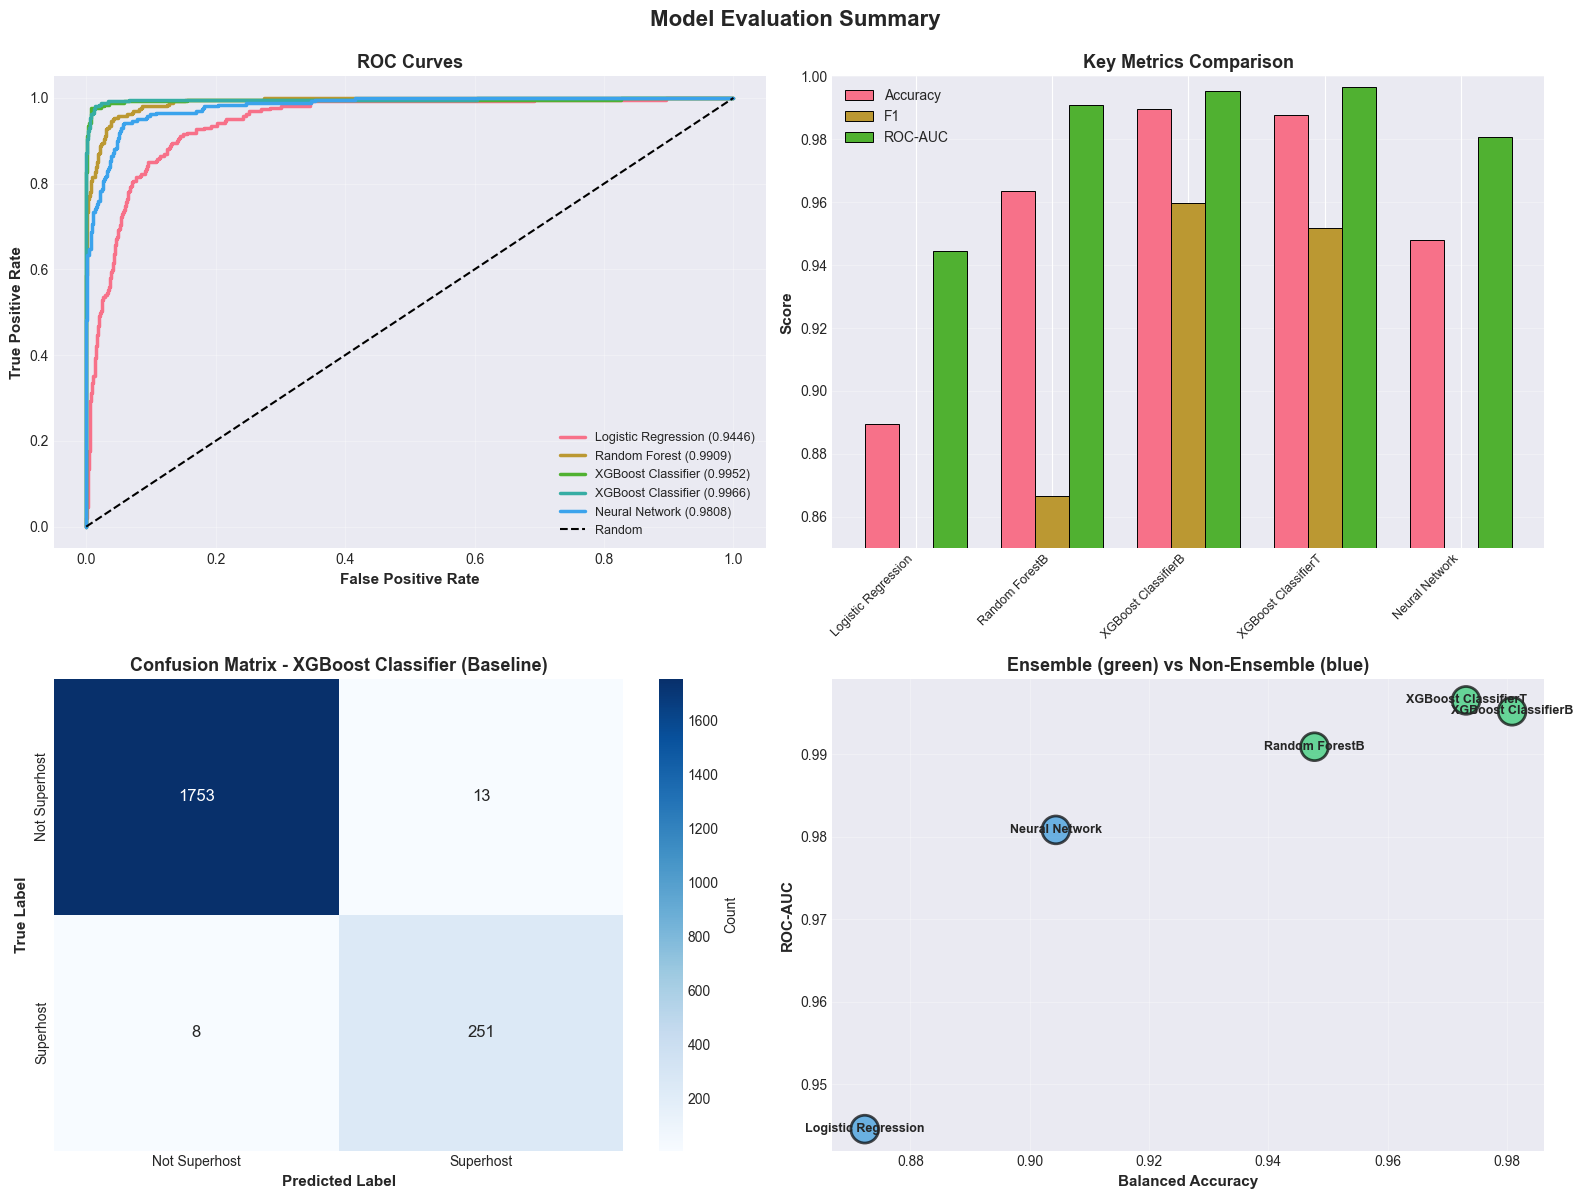

In [18]:
# Visualizations
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: ROC Curves
ax = axes[0, 0]

for model_name, results in evaluations.items():
    # Get predictions and probabilities
    if model_name == "Neural Network":
        y_pred = results["test_predictions"]
        y_prob = results["test_probabilities"]
    else:
        model = models[model_name]
        y_pred = model.predict(X_test_np)
        y_prob = model.predict_proba(X_test_np)[:, 1]

    fpr, tpr, _ = roc_curve(y_test_np, y_prob)
    roc_auc = results["test"]["ROC-AUC"]

    ax.plot(
        fpr,
        tpr,
        label=f"{model_name.replace(' (Baseline)', '').replace(' (Tuned)', '')} ({roc_auc:.4f})",
        linewidth=2.5,
    )

ax.plot([0, 1], [0, 1], "k--", label="Random", linewidth=1.5)
ax.set_xlabel("False Positive Rate", fontsize=11, fontweight="bold")
ax.set_ylabel("True Positive Rate", fontsize=11, fontweight="bold")
ax.set_title("ROC Curves", fontsize=13, fontweight="bold")
ax.legend(loc="lower right", fontsize=9)
ax.grid(alpha=0.3)

# Panel 2: Key Metrics Comparison
ax = axes[0, 1]

metrics_key = ["Accuracy", "F1", "ROC-AUC"]
x = np.arange(len(evaluations))
width = 0.25

for i, metric in enumerate(metrics_key):
    scores = [evaluations[m]["test"][metric] for m in evaluations.keys()]
    ax.bar(x + i * width, scores, width, label=metric, edgecolor="black", linewidth=0.7)

ax.set_ylabel("Score", fontsize=11, fontweight="bold")
ax.set_title("Key Metrics Comparison", fontsize=13, fontweight="bold")
ax.set_xticks(x + width)
ax.set_xticklabels(
    [
        m.replace(" (Baseline)", "B").replace(" (Tuned)", "T")
        for m in evaluations.keys()
    ],
    rotation=45,
    ha="right",
    fontsize=9,
)
ax.legend(fontsize=10)
ax.grid(alpha=0.3, axis="y")
ax.set_ylim([0.85, 1.0])

# Panel 3: Confusion Matrix - Best Model
ax = axes[1, 0]

best_model = max(
    evaluations.keys(), key=lambda x: evaluations[x]["test"]["Balanced Accuracy"]
)
cm = evaluations[best_model]["confusion_matrix"]

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax,
    cbar=True,
    cbar_kws={"label": "Count"},
    annot_kws={"fontsize": 12},
)
ax.set_title(f"Confusion Matrix - {best_model}", fontsize=13, fontweight="bold")
ax.set_ylabel("True Label", fontsize=11, fontweight="bold")
ax.set_xlabel("Predicted Label", fontsize=11, fontweight="bold")
ax.set_xticklabels(["Not Superhost", "Superhost"], fontsize=10)
ax.set_yticklabels(["Not Superhost", "Superhost"], fontsize=10)

# Panel 4: Ensemble vs Non-Ensemble
ax = axes[1, 1]

ensemble_names = [
    k for k in evaluations.keys() if "XGBoost" in k or "Random Forest" in k
]
non_ensemble_names = [k for k in evaluations.keys() if "Logistic" in k or "Neural" in k]

balanced_acc = [evaluations[m]["test"]["Balanced Accuracy"] for m in evaluations.keys()]
roc_auc = [evaluations[m]["test"]["ROC-AUC"] for m in evaluations.keys()]
model_names = list(evaluations.keys())

colors = [
    "#2ecc71" if any(x in name for x in ["XGBoost", "Random Forest"]) else "#3498db"
    for name in model_names
]

scatter = ax.scatter(
    balanced_acc, roc_auc, s=400, alpha=0.7, c=colors, edgecolors="black", linewidth=2
)

for i, name in enumerate(model_names):
    short_name = name.replace(" (Baseline)", "B").replace(" (Tuned)", "T")
    ax.annotate(
        short_name,
        (balanced_acc[i], roc_auc[i]),
        fontsize=9,
        ha="center",
        va="center",
        fontweight="bold",
    )

ax.set_xlabel("Balanced Accuracy", fontsize=11, fontweight="bold")
ax.set_ylabel("ROC-AUC", fontsize=11, fontweight="bold")
ax.set_title("Ensemble (green) vs Non-Ensemble (blue)", fontsize=13, fontweight="bold")
ax.grid(alpha=0.3)

plt.suptitle("Model Evaluation Summary", fontsize=16, fontweight="bold", y=0.995)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_evaluation_summary.png", dpi=300, bbox_inches="tight")
print("Saved: model_evaluation_summary.png")
plt.show()

In [19]:
# Ensemble vs Non-Ensemble stats
ensemble_scores = np.mean(
    [
        [evaluations[m]["test"]["F1"] for m in ensemble_names],
        [evaluations[m]["test"]["ROC-AUC"] for m in ensemble_names],
    ],
    axis=1,
)
non_ensemble_scores = np.mean(
    [
        [evaluations[m]["test"]["F1"] for m in non_ensemble_names],
        [evaluations[m]["test"]["ROC-AUC"] for m in non_ensemble_names],
    ],
    axis=1,
)

print(f"\033[1mEnsemble Models (n={len(ensemble_names)}):\033[0m")
print(f"  Avg F1:     {ensemble_scores[0]:.4f}")
print(f"  Avg ROC-AUC: {ensemble_scores[1]:.4f}")

print(f"\033[1m\nNon-Ensemble Models (n={len(non_ensemble_names)}):\033[0m")
print(f"  Avg F1:     {non_ensemble_scores[0]:.4f}")
print(f"  Avg ROC-AUC: {non_ensemble_scores[1]:.4f}")

print(f"\033[1m\nBest Overall: {best_model}\033[0m")
print(
    f"  Balanced Accuracy: {evaluations[best_model]['test']['Balanced Accuracy']:.4f}"
)
print(f"  F1 Score:          {evaluations[best_model]['test']['F1']:.4f}")
print(f"  ROC-AUC:           {evaluations[best_model]['test']['ROC-AUC']:.4f}")

Ensemble Models (n=3):
  Avg F1:     0.9260
  Avg ROC-AUC: 0.9942

Non-Ensemble Models (n=2):
  Avg F1:     0.7346
  Avg ROC-AUC: 0.9627

Best Overall: XGBoost Classifier (Baseline)
  Balanced Accuracy: 0.9809
  F1 Score:          0.9598
  ROC-AUC:           0.9952


## Error Distribution


Total test samples: 2025
Correct predictions: 2004 (98.96%)
Misclassified: 21 (1.04%)

False Positives (predicted superhost, actually not): 13
False Negatives (predicted not superhost, actually is): 8

Average confidence:
  Correct predictions: 0.4878
  Misclassified: 0.2694

Confident errors (prob > 0.9 or < 0.1): 6


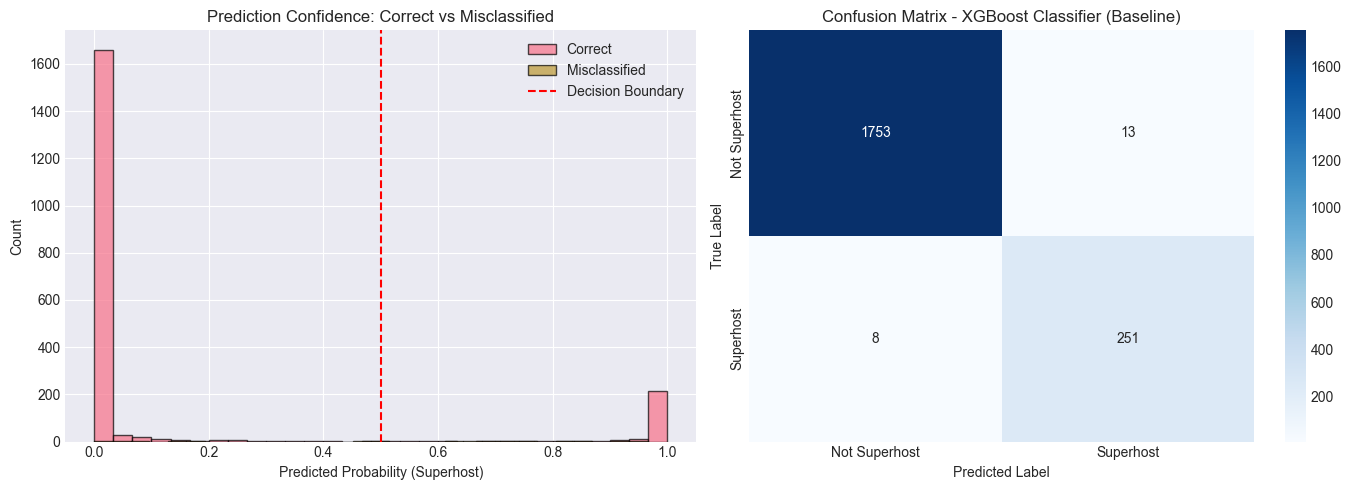

In [20]:
# Get predictions from best model
best_model_obj = models[best_model]
y_pred = best_model_obj.predict(X_test_np)
y_prob = best_model_obj.predict_proba(X_test_np)[:, 1]

# Identify misclassified samples
misclassified_idx = np.where(y_pred != y_test_np)[0]
correct_idx = np.where(y_pred == y_test_np)[0]

print(f"\nTotal test samples: {len(y_test_np)}")
print(
    f"Correct predictions: {len(correct_idx)} ({len(correct_idx) / len(y_test_np) * 100:.2f}%)"
)
print(
    f"Misclassified: {len(misclassified_idx)} ({len(misclassified_idx) / len(y_test_np) * 100:.2f}%)"
)

# False Positives vs False Negatives
fp_idx = np.where((y_pred == 1) & (y_test_np == 0))[0]
fn_idx = np.where((y_pred == 0) & (y_test_np == 1))[0]

print(f"\nFalse Positives (predicted superhost, actually not): {len(fp_idx)}")
print(f"False Negatives (predicted not superhost, actually is): {len(fn_idx)}")

# Analyze confidence of misclassifications
misclassified_probs = y_prob[misclassified_idx]
correct_probs = y_prob[correct_idx]

print(f"\nAverage confidence:")
print(f"  Correct predictions: {np.abs(correct_probs - 0.5).mean():.4f}")
print(f"  Misclassified: {np.abs(misclassified_probs - 0.5).mean():.4f}")

# Find most confident errors (high probability but wrong)
confident_errors_idx = misclassified_idx[np.abs(misclassified_probs - 0.5) > 0.4]
print(f"\nConfident errors (prob > 0.9 or < 0.1): {len(confident_errors_idx)}")

# Visualize error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prediction confidence for correct vs incorrect
axes[0].hist(correct_probs, bins=30, alpha=0.7, label="Correct", edgecolor="black")
axes[0].hist(
    misclassified_probs, bins=30, alpha=0.7, label="Misclassified", edgecolor="black"
)
axes[0].axvline(0.5, color="red", linestyle="--", label="Decision Boundary")
axes[0].set_xlabel("Predicted Probability (Superhost)")
axes[0].set_ylabel("Count")
axes[0].set_title("Prediction Confidence: Correct vs Misclassified")
axes[0].legend()

# Confusion Matrix Heatmap
cm = evaluations[best_model]["confusion_matrix"]
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[1],
    xticklabels=["Not Superhost", "Superhost"],
    yticklabels=["Not Superhost", "Superhost"],
)
axes[1].set_title(f"Confusion Matrix - {best_model}")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "error_analysis.png", dpi=300, bbox_inches="tight")
plt.show()